## Challenge Apprentissage Automatique  
# Classification des pixels d'une image hyperspectrale  
Groupe : LAMBERT Tanguy, BUCHE Sylvain et GODET Louis-Xavier

In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib import cm

## I - Contexte et objectif  
### A - Chargement des données

Le fichier `houston.npz`contient l'image hyperspectrale qui nous intéresse :

In [2]:
houston = np.load('houston.npz')
hyp = houston["hyp_img"]
label = houston["label_img"]

print("Dimension de l'image = ", hyp.shape)
print("Dimension de l'ensemble des classifications = ", label.shape)

Dimension de l'image =  (1202, 4768, 48)
Dimension de l'ensemble des classifications =  (1202, 4768)


A partir de ce fichier, on obtient deux ensembles :
1. **hyp** : l'image hyperspectrale de 48 bandes de taille 1202x4768
2. **label** : les classes de chaque pixel de cette image de taille 1202x4768 (1 pixel = 1 classe)

### B - Visualisation des données

Dans un premier temps, visualisons l'image avec 3 bandes spectrales différentes :

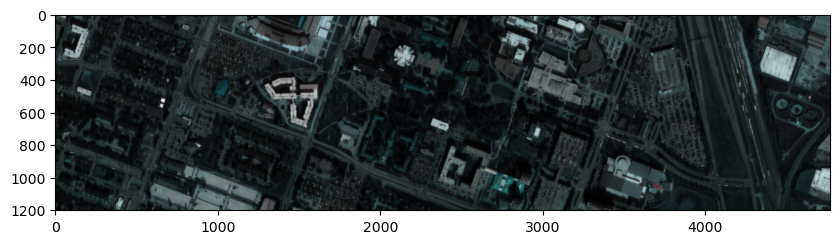

In [3]:
nbands=[10,21,22]

plt.figure(figsize=(10,15))
plt.imshow(hyp[:,:,nbands])
plt.show()

L'image `label` donne pour chaque pixel de l'image une information sur la classe du pixel avec la nomenclature suivante :  
  
**0.** Inconnu  
**1.** Herbes saines    
**2.** Herbes en état de stress hydrique  
**3.** Conifères  
**4.** Feuillus  
**5.** Bâtiments résidentiels  
**6.** Bâtiments non-résidentiels  
**7.** Routes  
**8.** Trottoirs  
**9.** Carrefour   
**10.** Grands axes routiers  
**11.** Stationnements asphaltés  
**12.** Voitures  

Regardons désormais l'ensemble des classes de chaque pixels, par l'intérmediaire d'une image avec pour chaque classe une couleur de pixel associée :

In [4]:
def viz_label_img(label_img):
    N = len(np.bincount(label_img.flatten())) # nombre d'étiquettes uniques
    colours = cm.get_cmap("tab10",N)
    cmap = colours(np.linspace(0, 1, N))  # obtenir une image RGB
    cmap[0,-1] = 0  # transparent pour les pixels à étiquetter
    display_img = cmap[label_img.flatten()]
    display_img = display_img.reshape((label_img.shape[0], label_img.shape[1], -1))
    return display_img

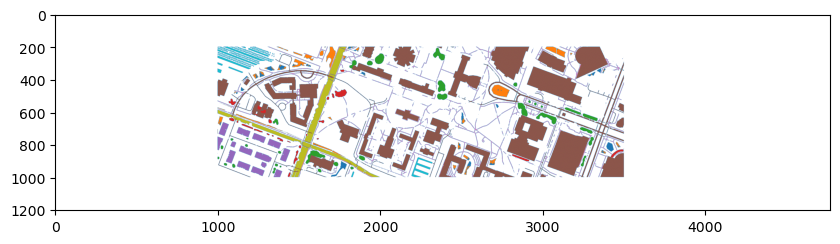

In [5]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(label))
plt.show()

Par l'intermédiaire de cette affichage, on voit très rapidement que la grande majorité des pixels ont la **classe 0** (pixels blancs). Ils n'ont aucunes étiquettes pour le moment. **Le but du challenge va donc être de prédire les classes de chaque pixel de l'image hyperspectrale, grâce notamment aux pixels déjà classifiées et différents de la classe 0**

## II - Préparation des données  
### A - Définition des données X et des classes y

La première chose à faire avant de travailler sur les modèles, est de préparer la structure et le contenu des données.

In [6]:
X = hyp[label != 0]
y = label[label != 0]
X_challenge = hyp.reshape((-1,48))

Ici on souhaite uniquement garder les pixels de l'image qui sont réellement classifiés, c'est à dire garder les pixels avec pour classe différente de 0. On supprime donc tous les 0 de l'ensemble "label" mais aussi les pixels qui ont pour classe 0 dans l'image "hyp".

### B - Répartition et séparation données d'apprentissage / données de tests.

In [7]:
classes, occurrences = np.unique(y, return_counts=True)

for classe, occurrence in zip(classes, occurrences):
    repartition = round((occurrence*100)/y.shape[0], 2);
    print(f"La classe {classe} apparaît {occurrence} fois ({repartition} % de l'image classifiée)")

La classe 1 apparaît 11820 fois (1.56 % de l'image classifiée)
La classe 2 apparaît 28180 fois (3.72 % de l'image classifiée)
La classe 3 apparaît 35779 fois (4.72 % de l'image classifiée)
La classe 4 apparaît 13367 fois (1.76 % de l'image classifiée)
La classe 5 apparaît 34125 fois (4.51 % de l'image classifiée)
La classe 6 apparaît 413636 fois (54.61 % de l'image classifiée)
La classe 7 apparaît 55268 fois (7.3 % de l'image classifiée)
La classe 8 apparaît 86094 fois (11.37 % de l'image classifiée)
La classe 9 apparaît 3085 fois (0.41 % de l'image classifiée)
La classe 10 apparaît 50607 fois (6.68 % de l'image classifiée)
La classe 11 apparaît 15247 fois (2.01 % de l'image classifiée)
La classe 12 apparaît 10176 fois (1.34 % de l'image classifiée)


On observe que la classe 6 est celle qui apparait le plus de fois dans les pixels labelisés (54.61% de l'image classifiée). 
À l'inverse, la classe 9 est celle qui apparait le moins parmis les pixels lablisés (0.41% de l'image classifiée). Ces répartitions sont importantes car pour le dataset d'apprentissage et de test, nous devons avoir des occurrences de classes équitables. En effet, il faut que le modèle soit en capacité de reconnaitre chaque classe et de les utiliser pour classifier.  
  
Il y a 3 différentes méthodes de séparation de données d'apprentissage :  

**1**. ShuffleSplit  
**2**. KFold  
**3**. StratifiedKFold   

A priori, "StratifiedKFold" est la méthode la plus adapté à ce type de problème. En effet, l'image ayant des classes plus représentées que d'autres, cette méthode pourra réquilibrer cette répartition dans les données d'apprentissage et données de tests. Cependant,  nous testerons ces 3 solutions sur les "nested cross validations".

In [8]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

## III - Génération automatique de modèle avec cross_validation imbriquée

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

def gen_nested_cross_validate(model, X, y, param_grid, inner_splits, outer_splits):
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=0)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=0)
    
    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=inner_cv)
    return cross_validate(grid_search, X, y, return_estimator=True, cv=outer_cv)

## IV - Tests des modèles  
### A - DummyClassifier

Le DummyClassifier est un modèle ignorant les données d'entrées (ici l'image). Ils possèdent différentes stratégies, notamment :  

**1**. **"most_frequent"** : prédit uniquement la classe la plus fréquente parmis y (ici la classe 6 comme observée au point **II**) 

**2**. **"stratified"** : prédit les classes au hasard avec une distribution correspondant à la fréquence de chaque classe  

**3**. **"uniform"** : prédit les classes au hasard de manière uniforme

In [10]:
from sklearn.dummy import DummyClassifier

# Test des 3 stratégies :
dummy_1 = DummyClassifier(strategy="most_frequent")
dummy_1.fit(X,y)
print("Score obtenu avec Dummy Classifier avec most_frequent :", dummy_1.score(X, y))

dummy_2 = DummyClassifier(strategy="stratified")
dummy_2.fit(X,y)
print("Score obtenu avec Dummy Classifier avec stratified :", dummy_2.score(X, y))

dummy_3 = DummyClassifier(strategy="uniform")
dummy_3.fit(X,y)
print("Score obtenu avec Dummy Classifier avec uniform :", dummy_3.score(X, y))

Score obtenu avec Dummy Classifier avec most_frequent : 0.5461377583894035
Score obtenu avec Dummy Classifier avec stratified : 0.32777956756414184
Score obtenu avec Dummy Classifier avec uniform : 0.08296319964509416


En observant ces résultats, on peut dire que la stratégie "most_frequent" est celle qui obtient le meilleur score de test avec environ 54%. Cependant, cela reste très mauvais et ne sera problablement pas le modèle que nous allons sélectionné. Il nous servira uniquement à justifier l'implémentation de modèles plus complexes avec des scores de tests plus élevées. 

In [11]:
best_dummy_model = dummy_1

### B -  LogisticRegression

Nous allons tester désormais avec le modèle de regression logistique de base. Nous allons ici utiliser un **StandardScaler** car ce modèle nécessite la standardisation des données afin d'obtenir de meilleurs résultats.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

log_reg_clf = LogisticRegression(solver="sag")
log_reg_clf_pipe = make_pipeline(StandardScaler(), log_reg_clf)

# Nested Cross Validate
param_grid = {
    "logisticregression__max_iter" : [100, 500],
    "logisticregression__C" : [1.0, 0.1]
}

log_reg_clf_cv = gen_nested_cross_validate(log_reg_clf_pipe, X, y, param_grid, 5, 3)

In [13]:
print(log_reg_clf_cv)
print("1", log_reg_clf_cv["estimator"][0].best_params_)
print("2", log_reg_clf_cv["estimator"][1].best_params_)
print("3", log_reg_clf_cv["estimator"][2].best_params_)

{'fit_time': array([1694.87456703, 1486.13351727, 1330.22373676]), 'score_time': array([0.27345943, 0.19961834, 0.17688394]), 'estimator': [GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='sag'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.1],
                         'logisticregression__max_iter': [100, 500]}), GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='sag'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.1],
     

In [ ]:
best_logreg_model = makepipeline(StandardScaler(), LogisticRegression(solver="sag", max_iter=500, C=1.0))

### C - Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

# Nested Cross Validate
param_grid = {
    "max_depth":[None, 5, 10]
}

tree_clf_cv = gen_nested_cross_validate(tree_clf, X, y, param_grid, 5, 3)

In [15]:
print(tree_clf_cv)
print("1", tree_clf_cv["estimator"][0].best_params_)
print("2", tree_clf_cv["estimator"][1].best_params_)
print("3", tree_clf_cv["estimator"][2].best_params_)

{'fit_time': array([86.52729726, 76.103652  , 77.02225709]), 'score_time': array([0.07842922, 0.07867122, 0.08861017]), 'estimator': [GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10]}), GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10]}), GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10]})], 'test_score': array([0.71374306, 0.71306063, 0.64257846])}
1 {'max_depth': None}
2 {'max_depth': None}
3 {'max_depth': None}


In [16]:
best_tree_model = tree_clf

### D - RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

r_forest_clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Nested Cross Validate
param_grid = {
    "n_estimators": [150],
    "max_depth": [None],
    "min_samples_leaf": [1, 10]
}

r_forest_clf_cv = gen_nested_cross_validate(r_forest_clf, X, y, param_grid, 5, 3)

In [ ]:
print(r_forest_clf_cv)
print("1", r_forest_clf_cv["estimator"][0].best_params_)
print("2", r_forest_clf_cv["estimator"][1].best_params_)
print("3", r_forest_clf_cv["estimator"][2].best_params_)

In [ ]:
best_randomforest_model =  RandomForestClassifier(n_estimators=150, max_depth=None, min_samples_leaf=1, random_state=0, n_jobs=-1)

### E - HistGradientBoostingClassifier

In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boost_clf = HistGradientBoostingClassifier(max_iter=35, random_state=0, n_iter_no_change=3)

# Nested Cross Validate
param_grid = {
    "max_iter":[35],
    "n_iter_no_change":[3]
}

hist_gradient_boost_clf_cv = gen_nested_cross_validate(hist_gradient_boost_clf, X, y, param_grid, 5, 3)

In [19]:
print(hist_gradient_boost_clf_cv)
print("1", hist_gradient_boost_clf_cv["estimator"][0].best_params_)
print("2", hist_gradient_boost_clf_cv["estimator"][1].best_params_)
print("3", hist_gradient_boost_clf_cv["estimator"][2].best_params_)

{'fit_time': array([154.10060501, 145.37866211, 144.00293064]), 'score_time': array([2.82434416, 4.3386569 , 3.1937294 ]), 'estimator': [GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=HistGradientBoostingClassifier(max_iter=35,
                                                      n_iter_no_change=3,
                                                      random_state=0),
             n_jobs=-1, param_grid={'max_iter': [35], 'n_iter_no_change': [3]}), GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
             estimator=HistGradientBoostingClassifier(max_iter=35,
                                                      n_iter_no_change=3,
                                                      random_state=0),
             n_jobs=-1, param_grid={'max_iter': [35], 'n_iter_no_change': [3]}), GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None),
       

In [20]:
best_hgb_model = hist_gradient_boost_clf

## V - Metrics

Nous allons observer deux métriques pour chaque modèle testé précédemment :  
   
**1**. Le r2_score  

**2**. La matrice de confusion

### A - Entrainement et prédictions sur l'image complète de chaque modèle

In [13]:
from sklearn.metrics import accuracy_score

# Dummy
best_dummy_model.fit(X,y)
dummy_predict = best_dummy_model.predict(X_challenge)
dummy_predict = dummy_predict.reshape(label.shape)
y_dummy_predict = dummy_predict[label != 0]

print("Accuracy = ", accuracy_score(y, y_dummy_predict))

Accuracy =  0.5461377583894035


In [ ]:
# LogisticRegression
best_logreg_model.fit(X,y)
logreg_predict = best_logreg_model.predict(X_challenge)
logreg_predict = logreg_predict.reshape(label.shape)
y_logreg_predict = logreg_predict[label != 0]

print("Accuracy = ", accuracy_score(y, y_logreg_predict))

In [17]:
# DecisionTreeClassifier
best_tree_model.fit(X,y)
tree_predict = best_tree_model.predict(X_challenge)
tree_predict = tree_predict.reshape(label.shape)
y_tree_predict = tree_predict[label != 0]

print("Accuracy = ", accuracy_score(y, y_tree_predict))

Accuracy =  0.9975534207218532


In [ ]:
# RandomForest
best_randomforest_model.fit(X,y)
rf_predict = best_rf_model.predict(X_challenge)
rf_predict = rf_predict.reshape(label.shape)
y_rf_predict = rf_predict[label != 0]

print("Accuracy = ", accuracy_score(y, y_rf_predict))

In [21]:
# HistGradientBoosting
best_hgb_model.fit(X,y)
hgb_predict = best_hgb_model.predict(X_challenge)
hgb_predict = hgb_predict.reshape(label.shape)
y_hgb_predict = hgb_predict[label != 0]

print("Accuracy = ", accuracy_score(y, y_hgb_predict))

Accuracy =  0.8565971818786772


### B - R2 Score

In [ ]:
from sklearn.metrics import r2_score

dummy_score = r2_score(y, y_dummy_predict)
logreg_score = r2_score(y, y_logreg_predict)
tree_score = r2_score(y, y_tree_predict)
rf_score = r2_score(y, y_rf_predict)
hgb_score = r2_score(y, y_hgb_predict)

print("Dummy score r2 : ", dummy_score)
print("Logistic Regression score r2 : ", logreg_score)
print("Tree score r2 : ", tree_score)
print("Random Forest r2 : ", rf_score)
print("Hist score r2 : ", hgb_score)

### C - Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix

dummy_score = confusion_matrix(y, y_dummy_predict, normalize = "true")
log_reg_score = confusion_matrix(y, y_logreg_predict, normalize = "true")
tree_score = confusion_matrix(y, y_tree_predict, normalize = "true")
rf_score = confusion_matrix(y, y_rf_predict, normalize = "true")
hist_score = confusion_matrix(y, y_hgb_predict, normalize = "true")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_matrix = [dummy_score, pred_log_reg_score, tree_score, rf_score, hist_score]
titles = ["Dummy Classifier", " Logistic Regression", "Decision Tree", "Random Forest", "HistGradient Boosting Classifier"]

for i in range(len(confusion_matrix)):
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix[i], display_labels=classes)
    disp.plot(ax=ax)
    plt.title(titles[i])
    plt.show()

## VI - Prédicition de chaque modèle

Pour chaque modèle entrainé, nous allons enfin afficher la prédiction de chaque classe de chaque pixel de l'image.

### A - Dummy

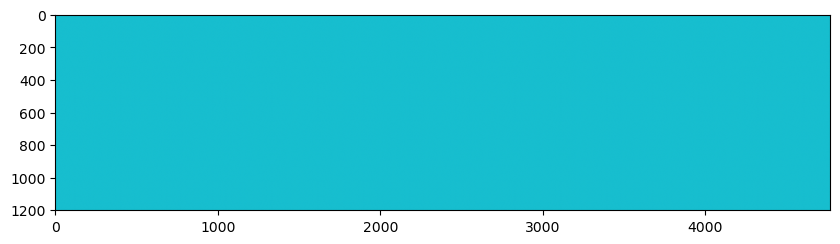

In [22]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(dummy_predict))
plt.show()

Le dummy ayant prédit pour chaque pixel la classe la plus fréquente, on obtient une image unifiée. C'est évidemment ce qu'on ne souhaite pas.

### B - LogisticRegression

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(logreg_predict))
plt.show()

### C - DecisionTreeClassifier

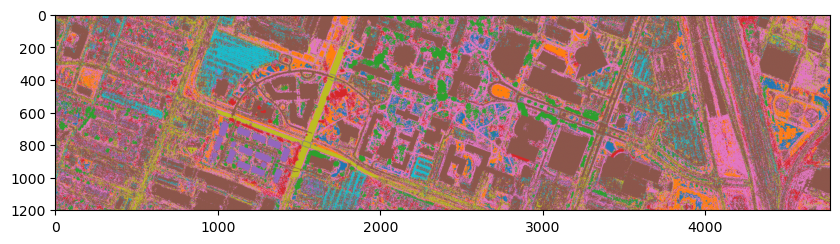

In [23]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(tree_predict))
plt.show()

### D - RandomForestClassifier

In [ ]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(rf_predict))
plt.show()

### E - HistGradientBoostingClassifier

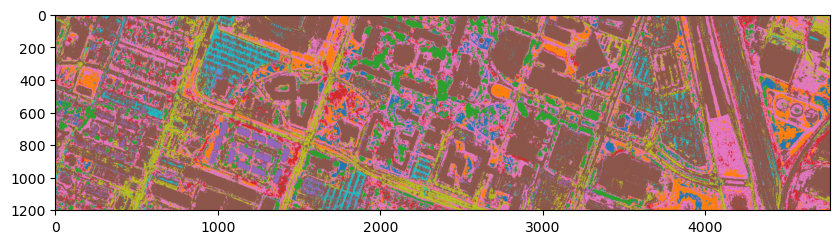

In [24]:
plt.figure(figsize=(10,15))
plt.imshow(viz_label_img(hgb_predict))
plt.show()